In [ ]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.transforms import v2
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from basemodel import Net
from batch_n_model import BatchNormNet
from dropout_model import DropoutNet
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np


In [ ]:
seed = 10  # for reproduceibility 

random.seed(seed)

np.random.seed(seed)

torch.manual_seed(seed)

In [3]:
# Standard augmentations 1
standard_augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.RandomRotation(degrees=15),  # Random rotation (±15 degrees)
        transforms.RandomResizedCrop(
            size=32, scale=(0.8, 1.0)
        ),  # Random crop and resize
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
# Standard augmentations 2
standard_augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomRotation(degrees=15), #  rotation (±15 degrees)
        transforms.RandomCrop(32, padding=4),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
# Standard augmentations 3
standard_augmentations = v2.Compose(
    [
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        # v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [25]:
advanced_augmentations = transforms.Compose(
    [
        transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# for different tensor normalization

train_dir = "./cinic10/train"
test_dir = "./cinic10/test"
val_dir = "./cinic10/valid"

batch_size = 8

trainset = datasets.ImageFolder(root=train_dir, transform=transform)


dataset_size = len(trainset)
subset_size = int(0.2 * dataset_size)
indices = torch.randperm(dataset_size)[:subset_size]
trainset = Subset(trainset, indices)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root=test_dir, transform=transform)

testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

valset = datasets.ImageFolder(root=val_dir, transform=transform)

valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [ ]:
net = Net()
# net = BatchNormNet()
# net = DropoutNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
# hyperparameters to test
dropout_rates = [0.2, 0.3, 0.5, 0,7]
weight_decays = [0.0001, 0.001, 0.01]

results = []

for dropout_rate in dropout_rates:
    for weight_decay in weight_decays:
        print(
            f"\nTraining with dropout_rate={dropout_rate}, weight_decay={weight_decay}"
        )

        net = DropoutNet(dropout_rate=dropout_rate)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=weight_decay)

        train_losses = []
        val_losses = []
        val_accuracies = []
        batch_val_accuracies = []  # To store validation accuracy for every iteration

        for epoch in range(6):  # loop over the dataset multiple times
            net.train()  
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 2000 == 1999:  # print every 2000 mini-batches
                    train_loss = running_loss / 2000
                    print(f"[{epoch + 1}, {i + 1:5d}] loss: {train_loss:.3f}")
                    train_losses.append(train_loss)
                    running_loss = 0.0

                    # run validation every 2000 batches
                    net.eval()  
                    val_loss = 0.0
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for data in valloader:
                            inputs, labels = data
                            outputs = net(inputs)
                            loss = criterion(outputs, labels)
                            val_loss += loss.item()
                            _, predicted = torch.max(outputs, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()

                    # validation loss and accuracy
                    val_loss /= len(valloader)
                    val_accuracy = 100 * correct / total

                    # validation metrics
                    val_losses.append(val_loss)
                    val_accuracies.append(val_accuracy)
                    batch_val_accuracies.append(
                        val_accuracy
                    )  # for every iteration

                    # validation accuracy for the current iteration
                    print(f"Validation Accuracy: {val_accuracy:.2f}%")

            print(
                f"Epoch {epoch + 1}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%"
            )

        results.append(
            {
                "dropout_rate": dropout_rate,
                "weight_decay": weight_decay,
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
            }
        )

        PATH = f"dropout/cinic_net{dropout_rate}dr.{weight_decay}wd.pth"
        torch.save(net.state_dict(), PATH)

import pickle

with open("regularization_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [56]:
with open("regularization_results.pkl", "rb") as f:
    metrics = pickle.load(f)

print(metrics)

[{'dropout_rate': 0.2, 'weight_decay': 0.0001, 'train_losses': [1.8279634197950363, 1.5594770342707633, 1.4514046443998814, 1.4181599644422531, 1.3784202342927456, 1.3408661631345749, 1.2851093962937594, 1.2698804827183485, 1.252236225694418, 1.2406911213845015, 1.2318437243625522, 1.182295880973339, 1.173749602869153, 1.17404315405339, 1.1727105459868907, 1.1589392673000694, 1.1090007209256292, 1.1346366178058087, 1.1288507033959032, 1.1385885378569365, 1.146899844840169, 1.0866355554647744, 1.0883474483639002, 1.0804481453970074, 1.083247565858066, 1.1043533402904868, 1.0351100813802332, 1.046699183166027, 1.062430968001485, 1.0818542776480318], 'val_losses': [1.6431865439017614, 1.541449954753452, 1.4494139640218682, 1.393712444271644, 1.3742593704866037, 1.3673184085797931, 1.2655461941265398, 1.2813717934878337, 1.2748160290635295, 1.2737678359703886, 1.2216489262498087, 1.234365667783386, 1.2447713378677765, 1.1850640977452198, 1.2232002348817885, 1.206923830458853, 1.20479089928

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

net = Net()
for epoch in range(4):  
    net.train() 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            train_loss = running_loss / 2000
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {train_loss:.3f}")
            train_losses.append(train_loss) 
            running_loss = 0.0

            net.eval()  #validation
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for data in valloader:
                    inputs, labels = data
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(valloader)
            val_accuracy = 100 * correct / total

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(
                f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%"
            )

    print(f"Epoch {epoch + 1} finished")

PATH = "./cinic_net.pth"
torch.save(net.state_dict(), PATH)

import pickle

with open("training_metrics.pkl", "wb") as f:
    pickle.dump(
        {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
        },
        f,
    )

print("Finished Training and Saved Metrics")

[1,  2000] loss: 2.047
Validation Loss: 1.881, Validation Accuracy: 29.27%
Epoch 1 finished
[2,  2000] loss: 1.696
Validation Loss: 1.638, Validation Accuracy: 39.55%
Epoch 2 finished
[3,  2000] loss: 1.546
Validation Loss: 1.621, Validation Accuracy: 41.50%
Epoch 3 finished
[4,  2000] loss: 1.444
Validation Loss: 1.507, Validation Accuracy: 44.75%
Epoch 4 finished
Finished Training and Saved Metrics


In [73]:
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

print(metrics)

{'train_losses': [2.0469890730381013, 1.6959264693558216, 1.545569599315524, 1.4439474429935217], 'val_losses': [1.8814831733359232, 1.6382899885932605, 1.6213304943992033, 1.5071141241523955], 'val_accuracies': [29.27, 39.55222222222222, 41.50111111111111, 44.74777777777778]}


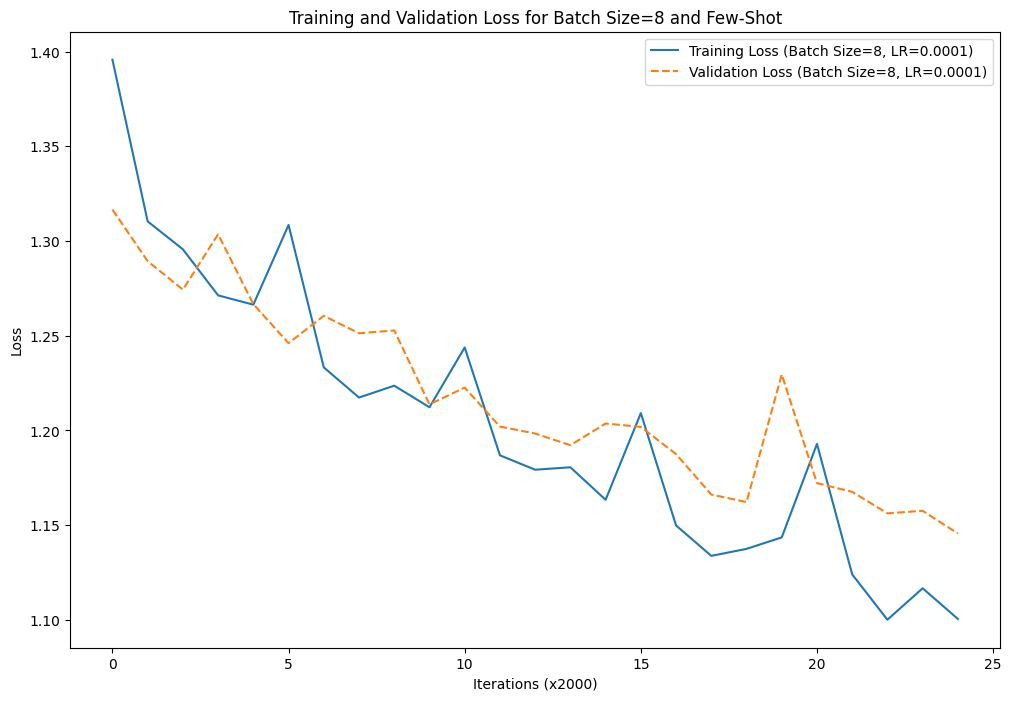

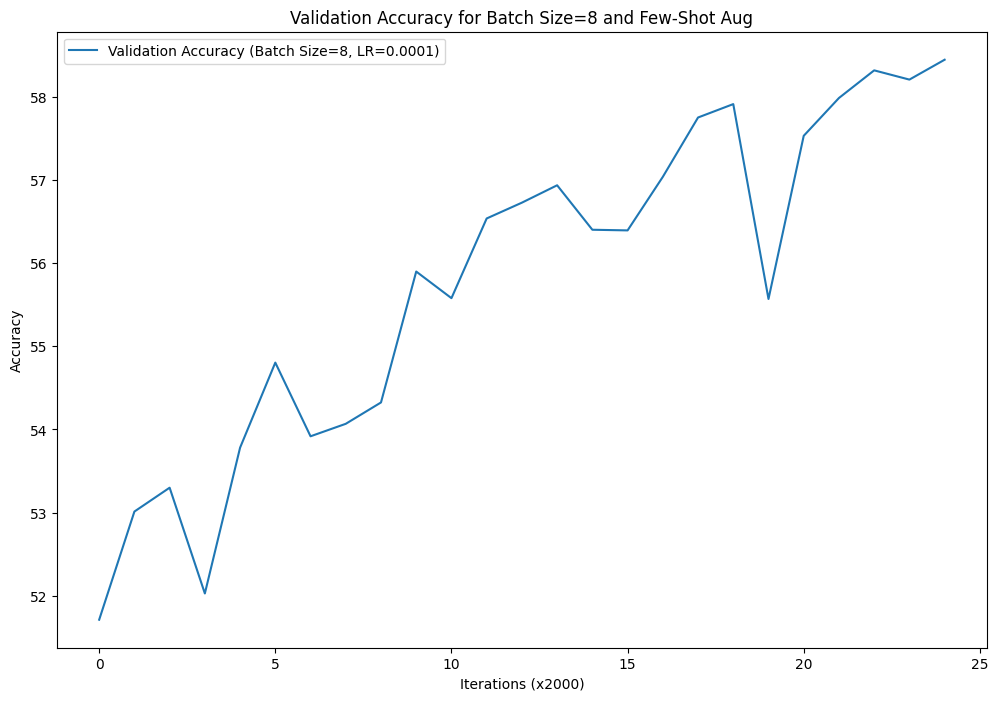

In [ ]:
results = [
    # {
    #     "batch_size": 4,  # 2 epochs
    #     "learning_rate": 0.001,
    #     "train_losses": [
    #         2.298, 2.083, 1.846, 1.726, 1.665, 1.648, 1.537, 1.482, 1.439, 1.406, 1.434, 1.327, 1.294, 1.285, 1.262, 1.328, 1.203, 1.183, 1.188, 1.172,
    #     ],
    #     "val_losses": [
    #         2.268, 1.932, 1.776, 1.703, 1.639, 1.589, 1.523, 1.466, 1.454, 1.370, 1.400, 1.298, 1.298, 1.276, 1.285, 1.283, 1.254, 1.207, 1.180, 1.190,
    #     ],
    #     "val_accuracies": [
    #         19.85, 27.97, 32.26, 36.80, 39.08, 40.58, 43.45, 45.47, 45.87, 49.27, 48.04, 52.31, 52.54, 52.99, 53.07, 53.29, 54.42, 56.18, 57.16, 56.91,
    #     ],
    # },
    # {   "batch_size": 8,  # 4 epochs
    #     "learning_rate": 0.005,
    #     'train_losses': [2.0469890730381013, 1.6959264693558216, 1.545569599315524, 1.4439474429935217], 
    #  'val_losses': [1.8814831733359232, 1.6382899885932605, 1.6213304943992033, 1.5071141241523955], 
    #  'val_accuracies': [29.27, 39.55222222222222, 41.50111111111111, 44.74777777777778]
    #  }
    # {
    #     "batch_size": 16,
    #     # "epochs": 10,
    #     "learning_rate": 0.001,
    #     "train_losses": [
    #         2.259, 1.986, 1.687, 1.632, 1.521, 1.469, 1.379, 1.347, 1.269, 1.257, 1.180, 1.182, 1.122, 1.105, 1.058, 1.061, 1.013, 1.007, 0.952, 0.977,
    #     ],
    #     "val_losses": [
    #         2.101, 1.878, 1.656, 1.606, 1.479, 1.511, 1.365, 1.404, 1.295, 1.247, 1.215, 1.184, 1.190, 1.176, 1.144, 1.139, 1.119, 1.118, 1.095, 1.086,
    #     ],
    #     "val_accuracies": [
    #         21.44, 30.44, 37.27, 40.67, 45.38, 43.80, 49.90, 48.76, 52.75, 53.92, 55.72, 56.80, 56.97, 57.88, 58.54, 58.96, 60.00, 59.86, 61.07, 61.09,
    #     ],
    # },
    # {
    #     "batch_size": 16,
    #     # "epochs": 10,
    #     "learning_rate": 0.01,
    #     "train_losses": [
    #         1.883, 1.568, 1.391, 1.363, 1.288, 1.281, 1.213, 1.239, 1.184, 1.223, 1.168, 1.211, 1.161, 1.192, 1.156, 1.186, 1.165, 1.183, 1.148, 1.198,
    #     ],
    #     "val_losses": [
    #         1.625, 1.609, 1.359, 1.442, 1.296, 1.345, 1.331, 1.297, 1.298, 1.285, 1.327, 1.312, 1.318, 1.288, 1.319, 1.353, 1.333, 1.362, 1.372, 1.343,
    #     ],
    #     "val_accuracies": [
    #         39.15, 41.44, 50.07, 48.02, 52.90, 52.05, 53.01, 54.34, 54.77, 53.85, 53.96, 53.05, 53.92, 55.57, 54.11, 54.04, 54.05, 54.11, 53.17, 53.19,
    #     ],
    # },
    # {
    #     "batch_size": 32,
        # "epochs": 10, initial aug batch n
    #     "learning_rate": 0.001,
    #     "train_losses": [
    #         2.305864054918289, 2.3028444319963457, 2.302681132078171, 2.3027549921274186, 2.302716176867485, 2.3027538206577303, 2.3027233369350433, 2.3028070728778838, 2.302703616142273, 2.302752784609795, 2.30274683535099, 2.302825176000595, 2.3027174891233444, 2.302724853277206, 2.3027603163719177, 2.3027913732528686, 2.3027300209999084, 2.302741435170174, 2.3027320090532304, 2.3028555841445923,
    #     ],
    #     "val_losses": [
    #         2.3028917312198214, 2.3026580093807643, 2.3026875496758357, 2.3027046918233234, 2.3027014495425755, 2.3026960847642686, 2.3027375937143963, 2.30265793800354, 2.3026726484086777, 2.3027181386735704, 2.3026912450578476, 2.3026426076253257, 2.3026648759206134, 2.302755093553331, 2.302691149817573, 2.3026623009999594, 2.3026333809746635, 2.302700257280138, 2.302752923880683, 2.302617335340712,
    #     ],
    #     "val_accuracies": [
    #         10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
    #     ],
    # },
    # {
    #     "batch_size": 32,
    #     # "epochs": 10, second aug batch n
    #     "learning_rate": 0.001,
    #     "train_losses": [
    #         2.3122094821929933, 2.3120008836984636, 2.31158751809597, 2.3130766813755037, 2.3131444026231764, 2.3110424573421477, 2.3126065418720247, 2.312603454351425, 2.3116492286920547, 2.312275418519974, 2.3119571554660796, 2.311083942294121, 2.3116035095453262, 2.312195185303688, 2.311570158958435, 2.313030219197273, 2.3116115320920945, 2.311360048890114, 2.3118602613210677, 2.313078234910965,
    #     ],
    #     "val_losses": [
    #         2.3101875450134277, 2.3101875450134277, 2.310253649648031, 2.310253649648031, 2.310089395353529, 2.310089395353529, 2.310366474787394, 2.310366474787394, 2.309882085800171, 2.309882085800171, 2.310126470141941, 2.310126470141941, 2.309965940899319, 2.309965940899319, 2.3097164757622615, 2.3097164757622615, 2.3102151868184406, 2.3102151868184406, 2.3102704984876845, 2.3102704984876845,
    #     ],
    #     "val_accuracies": [
    #         10.258888888888889, 10.258888888888889, 10.237777777777778, 10.237777777777778, 10.221111111111112, 10.221111111111112, 10.195555555555556, 10.195555555555556, 10.305555555555555, 10.305555555555555, 10.212222222222222, 10.212222222222222, 10.251111111111111, 10.251111111111111, 10.367777777777778, 10.367777777777778, 10.213333333333333, 10.213333333333333, 10.196666666666667, 10.196666666666667,
    #     ],
    # },
    # {
    #     "batch_size": 32,
    #     # "epochs": 10, adv aug batch n new norm
    #     "learning_rate": 0.001,
    #     "train_losses": [
    #         2.3121587479114534, 2.31069912648201, 2.3107385230064392, 2.3117535313367843, 2.311599676609039, 2.3116428509950637, 2.3110876915454863, 2.3113217550516127, 2.3116099145412443, 2.310767778277397,
    #     ],
    #     "val_losses": [
    #         2.311120722669323, 2.3111041280412183, 2.3110231289522867, 2.3108888704752184, 2.310992488223719, 2.3111027138028923, 2.3108542763885978, 2.3110779871772795, 2.311009757933225, 2.311237847470237,
    #     ],
    #     "val_accuracies": [
    #         10.126666666666667, 10.114444444444445, 10.132222222222222, 10.122222222222222, 10.113333333333333, 10.144444444444444, 10.12888888888889, 10.13888888888889, 10.12, 10.12,
    #     ],
    # },
    # {
    #     "batch_size": 8,
    #     # "epochs": 5, third aug batch n new norm
    #     "learning_rate": 0.001,
    #     "train_losses": [
    #         2.3152691680192947, 2.316142929673195, 2.3124834020137786, 2.3169958389997483, 2.3129214515686036, 2.3127307842969893, 2.3144428409337996, 2.3141266211271287, 2.316130161523819, 2.3154185066223145, 2.313767751812935, 2.3151863263845445, 2.3144398206472396, 2.314872950911522, 2.3135192084312437, 2.3132796128988264, 2.313454031944275, 2.315017724275589, 2.314689298033714, 2.3148474624156954, 2.3159287691116335, 2.314695286154747, 2.314837017059326, 2.313534850358963, 2.3121173713207246,
    #     ],
    #     "val_losses": [
    #         2.311586594443851, 2.311586594443851, 2.311586594443851, 2.311586594443851, 2.311586594443851, 2.3115122862392004, 2.3115122862392004, 2.3115122862392004, 2.3115122862392004, 2.3115122862392004, 2.311335394499037, 2.311335394499037, 2.311335394499037, 2.311335394499037, 2.311335394499037, 2.3111160354826183, 2.3111160354826183, 2.3111160354826183, 2.3111160354826183, 2.3111160354826183, 2.3112840191841126, 2.3112840191841126, 2.3112840191841126, 2.3112840191841126, 2.3112840191841126,
    #     ],
    #     "val_accuracies": [
    #         10.166666666666666, 10.166666666666666, 10.166666666666666, 10.166666666666666, 10.166666666666666, 10.176666666666666, 10.176666666666666, 10.176666666666666, 10.176666666666666, 10.176666666666666, 10.156666666666666, 10.156666666666666, 10.156666666666666, 10.156666666666666, 10.156666666666666, 10.16, 10.16, 10.16, 10.16, 10.16, 10.166666666666666, 10.166666666666666, 10.166666666666666, 10.166666666666666, 10.166666666666666,
    #     ],
    # },
    # {
    #     "batch_size": 8,
    #     # "epochs": 5, third with min aug batch n new norm
    #     "learning_rate": 0.0001,
    #     "train_losses": [
    #         2.22175791400671, 1.9782981895804406, 1.849798652291298, 1.7745744935870171, 1.7295454474985599, 1.782186096727848, 1.
    #     ],
    #     "val_losses": [
    #         2.088633992608388, 1.8604154269218445, 1.783687690586514, 1.731633824274275, 1.695914229885737, 1.6641285533216263, 1.6611848474317126, 1.6135402336147096, 1.5718620368321736, 1.549421004401313, 1.5419176987700993, 1.505039279466205, 1.5184552214688725, 1.4773716097606553, 1.5102219683541191, 1.4535456521405115, 1.4551031257298257, 1.4553631482786602, 1.42050989932749, 1.3919790663229095, 1.399819870396455, 1.3744234072499806, 1.3609960268245802, 1.3896230876955722, 1.387644003250864,
    #     ],
    #     "val_accuracies": [
    #         24.083333333333332, 30.147777777777776, 32.653333333333336, 35.33, 36.73555555555556, 38.64888888888889, 37.754444444444445, 39.617777777777775, 41.836666666666666, 42.663333333333334, 42.77111111111111, 44.66, 43.23111111111111, 44.79222222222222, 43.68, 46.09888888888889, 46.13777777777778, 46.15888888888889, 47.36888888888889, 48.785555555555554, 48.446666666666665, 49.47222222222222, 50.18, 49.221111111111114, 48.51,
    #     ],
    # },
    {
        "batch_size": 8,
        # "epochs": 5, third with no aug batch n new norm
        "learning_rate": 0.0001,
        "train_losses": [
            1.3957165067493915, 1.3103699593842029, 1.2956204734742642, 1.2713005127608776, 1.266397809535265, 1.308468565836549, 1.233279199331999, 1.2173663613721728, 1.2236206705719233, 1.2122355902493, 1.2437958260625601, 1.1868585411310195, 1.179256428822875, 1.1805510926246643, 1.1633755797147751, 1.2091477104723454, 1.1498279142677783, 1.1337726843804121, 1.1374637759104371, 1.1435276674330235, 1.192883289411664, 1.124004247687757, 1.100061479359865, 1.1166681549847126, 1.1004752042368053,
        ],
        "val_losses": [
            1.3165858786424, 1.2893635669443342, 1.274341478465663, 1.3035360165602632, 1.2666645238584942, 1.246087171336015, 1.2605013101127414, 1.2512942684339152, 1.2527825144350528, 1.2137569217955073, 1.222606948235631, 1.202024450418022, 1.1983661084453265, 1.1921842265046305, 1.2036462377806505, 1.2018619189103446, 1.1875022434754503, 1.1661510935836368, 1.1621584889216556, 1.2295315558877256, 1.1721632708936929, 1.167571261703968, 1.1562235993729697, 1.1575783671389024, 1.1455644397632943,
        ],
        "val_accuracies": [
            51.71333333333333, 53.013333333333335, 53.3, 52.028888888888886, 53.78111111111111, 54.803333333333335, 53.91777777777778, 54.06777777777778, 54.324444444444445, 55.897777777777776, 55.577777777777776, 56.535555555555554, 56.72555555555556, 56.934444444444445, 56.4, 56.39222222222222, 57.035555555555554, 57.74888888888889, 57.91, 55.56777777777778, 57.528888888888886, 57.983333333333334, 58.315555555555555, 58.20444444444445, 58.443333333333335,
        ],
    },
    # {
    #     "batch_size": 8,
    #     # 5 epochs, only resized crop, new norm, batch n
    #     "learning_rate": 0.0001,
    #     "train_losses": [
    #         1.3957165067493915, 1.3103699593842029, 1.2956204734742642, 1.2713005127608776, 1.266397809535265, 1.308468565836549, 1.233279199331999, 1.2173663613721728, 1.2236206705719233, 1.2122355902493, 1.2437958260625601, 1.1868585411310195, 1.179256428822875, 1.1805510926246643, 1.1633755797147751, 1.2091477104723454, 1.1498279142677783, 1.1337726843804121, 1.1374637759104371, 1.1435276674330235, 1.192883289411664, 1.124004247687757, 1.100061479359865, 1.1166681549847126, 1.1004752042368053,
    #     ],
    #     "val_losses": [
    #         1.3165858786424, 1.2893635669443342, 1.274341478465663, 1.3035360165602632, 1.2666645238584942, 1.246087171336015, 1.2605013101127414, 1.2512942684339152, 1.2527825144350528, 1.2137569217955073, 1.222606948235631, 1.202024450418022, 1.1983661084453265, 1.1921842265046305, 1.2036462377806505, 1.2018619189103446, 1.1875022434754503, 1.1661510935836368, 1.1621584889216556, 1.2295315558877256, 1.1721632708936929, 1.167571261703968, 1.1562235993729697, 1.1575783671389024, 1.1455644397632943,
    #     ],
    #     "val_accuracies": [
    #         51.71333333333333, 53.013333333333335, 53.3, 52.028888888888886, 53.78111111111111, 54.803333333333335, 53.91777777777778, 54.06777777777778, 54.324444444444445, 55.897777777777776, 55.577777777777776, 56.535555555555554, 56.72555555555556, 56.934444444444445, 56.4, 56.39222222222222, 57.035555555555554, 57.74888888888889, 57.91, 55.56777777777778, 57.528888888888886, 57.983333333333334, 58.315555555555555, 58.20444444444445, 58.443333333333335,
    #     ],
    # },
    #     {
    #      "batch_size": 16,
    #     # "epochs": 10,
    #     'learning_rate': 0.1,
    #     "train_losses": [4607157.313, 2.318, 2.316, 2.317, 2.316, 2.317, 2.316, 2.318, 2.316, 2.317, 2.316, 2.318, 2.316, 2.317, 2.316, 2.318, 2.316, 2.317, 2.317, 2.316],
    #     "val_losses": [2.313, 2.310, 2.325, 2.315, 2.315, 2.315, 2.318, 2.328, 2.319, 2.305, 2.314, 2.316, 2.319, 2.305, 2.314, 2.316, 2.325, 2.315, 2.318, 2.328],
    #     "val_accuracies": [10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00]
    # }
]

plt.figure(figsize=(12, 8))
for result in results:
    label = f'Batch Size={result["batch_size"]}, LR={result["learning_rate"]}'

    plt.plot(result["train_losses"], label=f"Training Loss ({label})")
    plt.plot(result["val_losses"], "--", label=f"Validation Loss ({label})")

plt.xlabel("Iterations (x2000)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Batch Size=8 and Few-Shot")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for result in results:
    label = f'Batch Size={result["batch_size"]}, LR={result["learning_rate"]}'
    plt.plot(result["val_accuracies"], label=f"Validation Accuracy ({label})")

plt.xlabel("Iterations (x2000)")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy for Batch Size=8 and Few-Shot Aug")
plt.legend()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DropoutNet().to(device) 
model.load_state_dict(torch.load("dropout/cinic_net0.2dr.0.001wd.pth"))
print("The model is loaded")

model.eval()

num_classes = 10  
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

all_labels = []
all_predictions = []

with torch.no_grad():
    length = len(testloader)
    for i, (inputs, labels) in enumerate(testloader):
        print(f"Testing batch {i + 1}/{length}")
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        #per-class accuracy counters
        for j in range(len(labels)):
            label = labels[j].item()
            pred = predicted[j].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

f1 = f1_score(all_labels, all_predictions, average="macro")
precision = precision_score(all_labels, all_predictions, average="macro")
recall = recall_score(all_labels, all_predictions, average="macro")
accuracy = accuracy_score(all_labels, all_predictions)

print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# calculate and print per-class accuracy
print("\nPer-Class Accuracy:")
for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracy = class_correct[i] / class_total[i]
        print(
            f"Class {i}: {class_accuracy:.4f} (Correct: {int(class_correct[i])}, Total: {int(class_total[i])})"
        )
    else:
        print(f"Class {i}: No samples found")

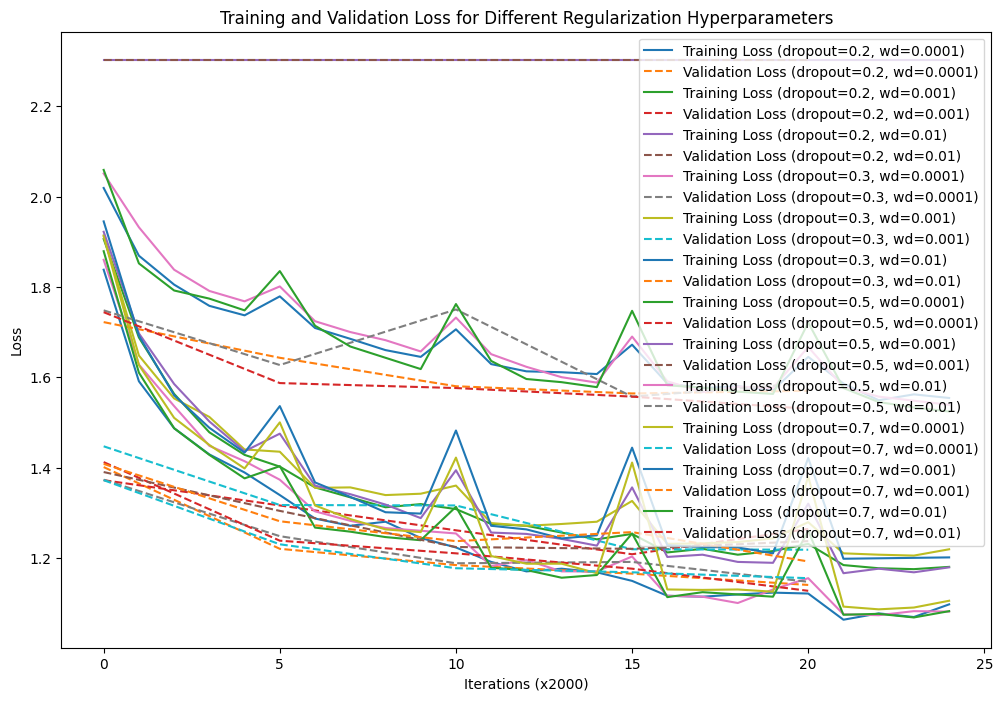

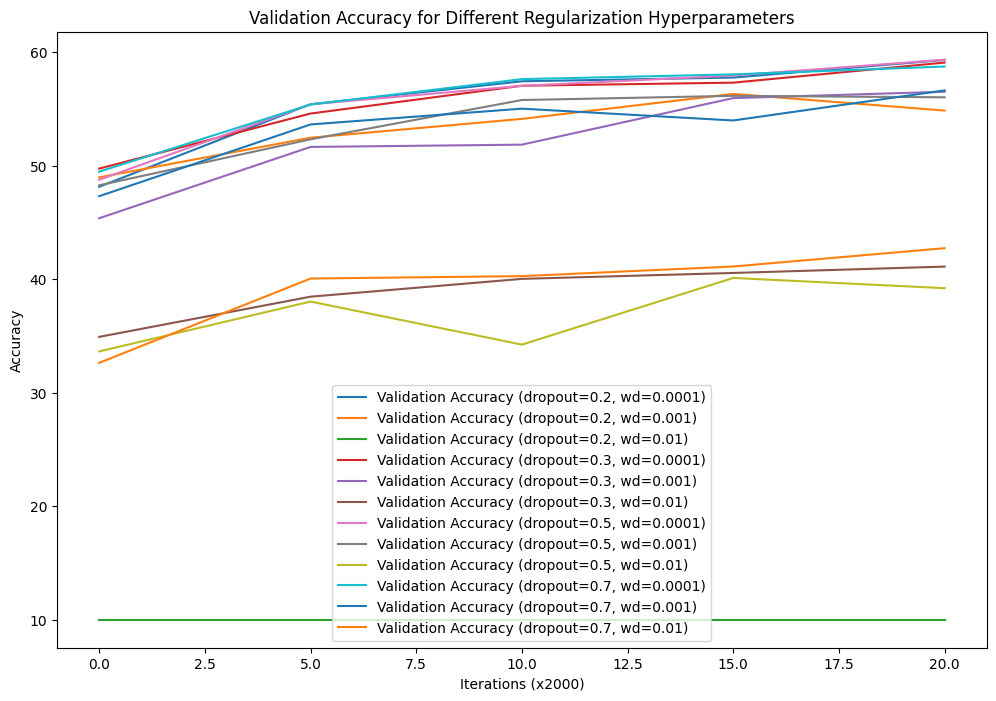

In [ ]:
results = [
    #  {
    #     "dropout_rate": 0.2, #10 epochs
    #     "weight_decay": 0.0001,
    #     "train_losses": [1.892, 1.628, 1.517, 1.470, 1.413, 1.377, 1.335, 1.290, 1.297, 1.273, 1.246, 1.231, 1.200, 1.205, 1.186, 1.191, 1.150, 1.134, 1.134, 1.150, 1.147, 1.097, 1.104, 1.117, 1.094, 1.125, 1.039, 1.075, 1.072, 1.075, 1.101, 1.020, 1.036, 1.048, 1.052, 1.075, 1.005, 1.023, 1.019, 1.042, 1.057, 0.997, 0.999, 1.014, 1.007, 1.055, 0.974, 0.980, 0.992, 0.997],
    #     "val_losses": [1.460, 1.246, 1.299, 1.213, 1.165, 1.185, 1.135, 1.148, 1.131, 1.107],
    #     "val_accuracies": [45.47, 54.59, 53.35, 56.87, 58.51, 57.92, 59.16, 59.31, 59.98, 60.91]
    # },
    # {
    #     "dropout_rate": 0.2, #lr 0.001, 12 epochs, 16 batch
    #     "weight_decay": 0.0001,
    #     "train_losses": [1.742, 1.476, 1.313, 1.243, 1.202, 1.150, 1.137, 1.090, 1.088, 1.045, 1.056, 1.006, 1.025, 0.970, 1.007, 0.950, 0.994, 0.935, 0.969, 0.909, 0.949, 0.897, 0.940, 0.882],
    #     "val_losses": [1.407, 1.256, 1.173, 1.140, 1.103, 1.142, 1.131, 1.091, 1.090, 1.101, 1.094, 1.101],
    #     "val_accuracies": [47.88, 54.66, 57.51, 59.00, 60.39, 59.37, 60.12, 61.43, 61.63, 61.16, 61.80, 61.93]
    # }
    {
        "dropout_rate": 0.2,
        "weight_decay": 0.0001,
        "train_losses": [
            1.838, 1.591, 1.487, 1.429, 1.389, 1.339, 1.287, 1.271, 1.280, 1.244, 1.223, 1.191, 1.170, 1.176, 1.168, 1.149, 1.116, 1.114, 1.119, 1.123, 1.121, 1.063, 1.077, 1.069, 1.097,
        ],
        "val_losses": [1.401, 1.220, 1.184, 1.165, 1.140],
        "val_accuracies": [48.13, 55.40, 57.42, 57.75, 59.30],
    },
    {
        "dropout_rate": 0.2,
        "weight_decay": 0.001,
        "train_losses": [
            1.906, 1.688, 1.563, 1.478, 1.428, 1.402, 1.356, 1.334, 1.312, 1.319, 1.308, 1.275, 1.271, 1.256, 1.241, 1.253, 1.212, 1.220, 1.207, 1.215, 1.231, 1.184, 1.177, 1.175, 1.180,
        ],
        "val_losses": [1.372, 1.316, 1.261, 1.208, 1.264],
        "val_accuracies": [48.96, 52.45, 54.11, 56.31, 54.84],
    },
    {
        "dropout_rate": 0.2,
        "weight_decay": 0.01,
        "train_losses": [
            2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303, 2.303,
        ],
        "val_losses": [2.303, 2.303, 2.303, 2.303, 2.303],
        "val_accuracies": [10.00, 10.00, 10.00, 10.00, 10.00],
    },
    {
        "dropout_rate": 0.3,
        "weight_decay": 0.0001,
        "train_losses": [
            1.860, 1.628, 1.536, 1.448, 1.414, 1.373, 1.303, 1.282, 1.266, 1.260, 1.254, 1.182, 1.195, 1.170, 1.170, 1.203, 1.116, 1.114, 1.100, 1.130, 1.155, 1.075, 1.073, 1.082, 1.081,
        ],
        "val_losses": [1.373, 1.248, 1.188, 1.191, 1.147],
        "val_accuracies": [49.73, 54.58, 57.03, 57.30, 59.07],
    },
    {
        "dropout_rate": 0.3,
        "weight_decay": 0.001,
        "train_losses": [
            1.914, 1.648, 1.553, 1.512, 1.440, 1.435, 1.355, 1.356, 1.339, 1.342, 1.360, 1.277, 1.271, 1.275, 1.280, 1.326, 1.231, 1.232, 1.235, 1.243, 1.279, 1.210, 1.207, 1.205, 1.219,
        ],
        "val_losses": [1.447, 1.317, 1.316, 1.219, 1.218],
        "val_accuracies": [45.36, 51.64, 51.84, 55.94, 56.50],
    },
    {
        "dropout_rate": 0.3,
        "weight_decay": 0.01,
        "train_losses": [
            2.019, 1.869, 1.805, 1.758, 1.737, 1.779, 1.709, 1.685, 1.660, 1.645, 1.706, 1.629, 1.613, 1.611, 1.607, 1.672, 1.586, 1.576, 1.580, 1.571, 1.645, 1.586, 1.549, 1.562, 1.554,
        ],
        "val_losses": [1.722, 1.643, 1.580, 1.564, 1.570],
        "val_accuracies": [34.91, 38.45, 40.02, 40.54, 41.10],
    },
    {
        "dropout_rate": 0.5,
        "weight_decay": 0.0001,
        "train_losses": [
            1.879, 1.610, 1.487, 1.428, 1.376, 1.403, 1.267, 1.258, 1.246, 1.239, 1.313, 1.178, 1.173, 1.156, 1.162, 1.254, 1.113, 1.124, 1.119, 1.114, 1.260, 1.074, 1.076, 1.068, 1.082,
        ],
        "val_losses": [1.412, 1.238, 1.210, 1.176, 1.127],
        "val_accuracies": [48.75, 55.39, 57.02, 57.93, 59.32],
    },
    {
        "dropout_rate": 0.5,
        "weight_decay": 0.001,
        "train_losses": [
            1.922, 1.697, 1.585, 1.502, 1.436, 1.475, 1.360, 1.341, 1.318, 1.288, 1.394, 1.256, 1.253, 1.242, 1.227, 1.356, 1.202, 1.207, 1.191, 1.189, 1.320, 1.166, 1.176, 1.168, 1.179,
        ],
        "val_losses": [1.390, 1.304, 1.224, 1.220, 1.237],
        "val_accuracies": [48.26, 52.31, 55.77, 56.14, 56.01],
    },
    {
        "dropout_rate": 0.5,
        "weight_decay": 0.01,
        "train_losses": [
            2.051, 1.932, 1.838, 1.791, 1.768, 1.801, 1.724, 1.700, 1.682, 1.657, 1.732, 1.651, 1.623, 1.600, 1.588, 1.690, 1.591, 1.567, 1.579, 1.576, 1.667, 1.578, 1.557, 1.548, 1.539,
        ],
        "val_losses": [1.748, 1.627, 1.750, 1.557, 1.587],
        "val_accuracies": [33.63, 38.02, 34.23, 40.10, 39.20],
    },
    {
        "dropout_rate": 0.7,
        "weight_decay": 0.0001,
        "train_losses": [
            1.912, 1.627, 1.510, 1.450, 1.398, 1.500, 1.316, 1.286, 1.263, 1.257, 1.422, 1.204, 1.187, 1.187, 1.166, 1.411, 1.130, 1.129, 1.130, 1.125, 1.380, 1.092, 1.086, 1.090, 1.105,
        ],
        "val_losses": [1.372, 1.230, 1.177, 1.168, 1.155],
        "val_accuracies": [49.46, 55.37, 57.61, 58.03, 58.72],
    },
    {
        "dropout_rate": 0.7,
        "weight_decay": 0.001,
        "train_losses": [
            1.945, 1.692, 1.560, 1.488, 1.433, 1.536, 1.367, 1.335, 1.301, 1.298, 1.482, 1.271, 1.263, 1.243, 1.250, 1.444, 1.228, 1.224, 1.223, 1.210, 1.421, 1.198, 1.199, 1.200, 1.201,
        ],
        "val_losses": [1.408, 1.281, 1.237, 1.257, 1.192],
        "val_accuracies": [47.30, 53.62, 55.01, 53.97, 56.62],
    },
    {
        "dropout_rate": 0.7,
        "weight_decay": 0.01,
        "train_losses": [
            2.059, 1.852, 1.792, 1.774, 1.748, 1.835, 1.714, 1.668, 1.643, 1.618, 1.762, 1.636, 1.596, 1.589, 1.578, 1.747, 1.582, 1.577, 1.568, 1.563, 1.721, 1.576, 1.545, 1.533, 1.524,
        ],
        "val_losses": [1.744, 1.587, 1.576, 1.557, 1.530],
        "val_accuracies": [32.62, 40.05, 40.26, 41.11, 42.72],
    },
]

plt.figure(figsize=(12, 8))
for result in results:
    label = f'dropout={result["dropout_rate"]}, wd={result["weight_decay"]}'

    # training losses (logged every 2000 batches)
    plt.plot(result["train_losses"], label=f"Training Loss ({label})")

    val_x = [i * 5 for i in range(len(result["val_losses"]))]  # align validation points
    plt.plot(val_x, result["val_losses"], "--", label=f"Validation Loss ({label})")

plt.xlabel("Iterations (x2000)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Different Regularization Hyperparameters")
plt.legend()
plt.show()

# validation accuracy for each hyperparameter combination
plt.figure(figsize=(12, 8))
for result in results:
    label = f'dropout={result["dropout_rate"]}, wd={result["weight_decay"]}'

    val_x = [
        i * 5 for i in range(len(result["val_accuracies"]))
    ]  # align validation points
    plt.plot(val_x, result["val_accuracies"], label=f"Validation Accuracy ({label})")

plt.xlabel("Iterations (x2000)")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy for Different Regularization Hyperparameters")
plt.legend()
plt.show()